In [5]:
%load_ext autoreload
%autoreload 2

In [13]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter, defaultdict
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

from src.helpers import create_treemap_data
from src.data_loader import *

# Categories Structure

In [7]:
df_categories = read_categories()
df_categories

,article,category,level_1,level_2,level_3
0,Áedán mac Gabráin,subject.History.British_History.British_Histor...,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán mac Gabráin,subject.People.Historical_figures,People,Historical_figures,None
2,Åland,subject.Countries,Countries,None,None
3,Åland,subject.Geography.European_Geography.European_...,Geography,European_Geography,European_Countries
4,Édouard Manet,subject.People.Artists,People,Artists,None
...,...,...,...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements,Science,Chemistry,Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders,People,Religious_figures_and_leaders,None
5201,Zuid-Gelders,subject.Geography.European_Geography,Geography,European_Geography,None
5202,Zuid-Gelders,subject.Language_and_literature.Languages,Language_and_literature,Languages,None


In [8]:
# Count artices with multiple categories
df_categories['article'].value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

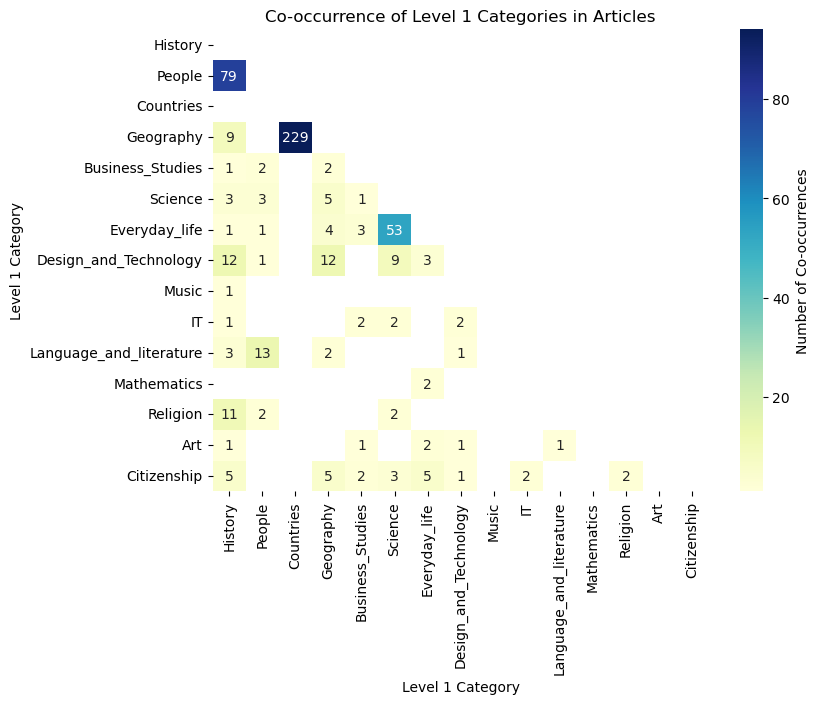

,Category Pair,Articles,Article Count
0,"(Countries, Geography)","[Åland, Éire, Abkhazia, Abu Dhabi, Afghanistan...",229
1,"(History, People)","[Áedán mac Gabráin, Óengus I of the Picts, Akh...",79
2,"(Everyday_life, Science)","[Almond, Aquarium, Avocado, Barley, Basil, Bea...",53
3,"(Language_and_literature, People)","[Augusta, Lady Gregory, Benjamin Britten, Coll...",13
4,"(History, Design_and_Technology)","[Avro Lancaster, Castra, Colossus of Rhodes, F...",12


In [9]:
# Step 1: Filter articles with multiple categories
multi_category_articles = df_categories.groupby('article').filter(lambda x: len(x) > 1)

# Step 2: Create pairs of category co-occurrences for each article with multiple categories
category_pairs = []
article_pairs = defaultdict(list)  # Dictionary to store articles for each unique category pair

for article in multi_category_articles['article'].unique():
    categories = multi_category_articles[multi_category_articles['article'] == article]['level_1'].unique()
    for pair in combinations(categories, 2):
        pair_set = frozenset(pair)  # Use a frozenset to ignore order
        category_pairs.append(pair_set)
        article_pairs[pair_set].append(article)  # Add the article to the respective pair list

# Step 3: Count the occurrences of each pair
pair_counts = Counter(category_pairs)

# Step 4: Convert pair_counts to a DataFrame for heatmap plotting
categories = df_categories['level_1'].unique()
heatmap_data = pd.DataFrame(0, index=categories, columns=categories)

# Step 5: Fill in the DataFrame with pair counts
for pair, count in pair_counts.items():
    cat1, cat2 = list(pair)
    heatmap_data.loc[cat1, cat2] = count
    heatmap_data.loc[cat2, cat1] = count  # Ensure symmetry

# Now, article_pairs contains each unique pair (unordered) with the list of associated articles

# Step 6: Plot the heatmap with a mask for the upper triangle, excluding zeros
mask = np.triu(np.ones_like(heatmap_data, dtype=bool)) | (heatmap_data == 0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", mask=mask,                      
            cbar_kws={'label': 'Number of Co-occurrences'}, fmt="g", robust=True)
plt.title("Co-occurrence of Level 1 Categories in Articles")
plt.xlabel("Level 1 Category")
plt.ylabel("Level 1 Category")
plt.show()

# Step 7: Convert article_pairs dictionary to a DataFrame with category pairs as sets and associated articles
article_pairs_df = pd.DataFrame([(pair, articles) for pair, articles in article_pairs.items()],
                                columns=['Category Pair', 'Articles'])

article_pairs_df['Article Count'] = article_pairs_df['Articles'].apply(len)  # Add count of articles
article_pairs_df = article_pairs_df.sort_values(by='Article Count', ascending=False).reset_index(drop=True)

# Display the DataFrame containing unique category pairs as sets and associated articles
article_pairs_df.head()


In [10]:
labels, parents, values, ids = create_treemap_data(df_categories)
print(labels,"\n",parents,"\n",values,"\n", ids)

['Art', 'Business_Studies', 'Citizenship', 'Countries', 'Design_and_Technology', 'Everyday_life', 'Geography', 'History', 'IT', 'Language_and_literature', 'Mathematics', 'Music', 'People', 'Religion', 'Science', 'Art', 'Artists', 'Business', 'Companies', 'Currency', 'Economics', 'Animal_and_Human_Rights', 'Community_organisations', 'Conflict_and_Peace', 'Culture_and_Diversity', 'Education', 'Environment', 'Law', 'Media', 'Politics_and_government', 'Air_and_Sea_transport', 'Architecture', 'Engineering', 'Railway_transport', 'Road_transport', 'Cartoons', 'Computer_and_Video_games', 'Drink', 'Everyday_life', 'Films', 'Food_and_agriculture', 'Games', 'Recreation', 'Sports', 'Sports_events', 'Sports_teams', 'Television', 'African_Geography', 'Antarctica', 'Central_and_South_American_Geography', 'Climate_and_the_Weather', 'European_Geography', 'General_Geography', 'Geography_of_Asia', 'Geography_of_Great_Britain', 'Geography_of_Oceania_Australasia', 'Geography_of_the_Middle_East', 'Geology_a

In [11]:
# Plotting the treemap
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [12]:
fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
))

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()


# Paths

In [14]:
# Step 1: Count the number of articles in each category
category_counts = df_categories.groupby('level_1')['article'].nunique().reset_index()
category_counts.columns = ['level_1', 'count']

# Step 2: Merge category counts back to df_categories
df_categories_with_counts = df_categories.merge(category_counts, on='level_1')

# Step 3: For each article, select the category with the lowest count (most specific)
df_main_category = df_categories_with_counts.sort_values('count').drop_duplicates('article', keep='first')

# Step 4: Keep only 'article' and its selected 'main category' (level_1)
df_main_category = df_main_category[['article', 'level_1']].reset_index(drop=True)

df_main_category

,article,level_1
0,"National Gallery, London",Art
1,Mona Lisa,Art
2,The Last Supper (Leonardo),Art
3,Baroque,Art
4,Fine art,Art
...,...,...
4593,Blacktip reef shark,Science
4594,Medicine,Science
4595,Shenzhou spacecraft,Science
4596,Black hole,Science


In [15]:
# Eg.
df_main_category[df_main_category['article'] == 'Abu Dhabi']

,article,level_1
927,Abu Dhabi,Countries


In [17]:
df_finished = read_finished_paths()

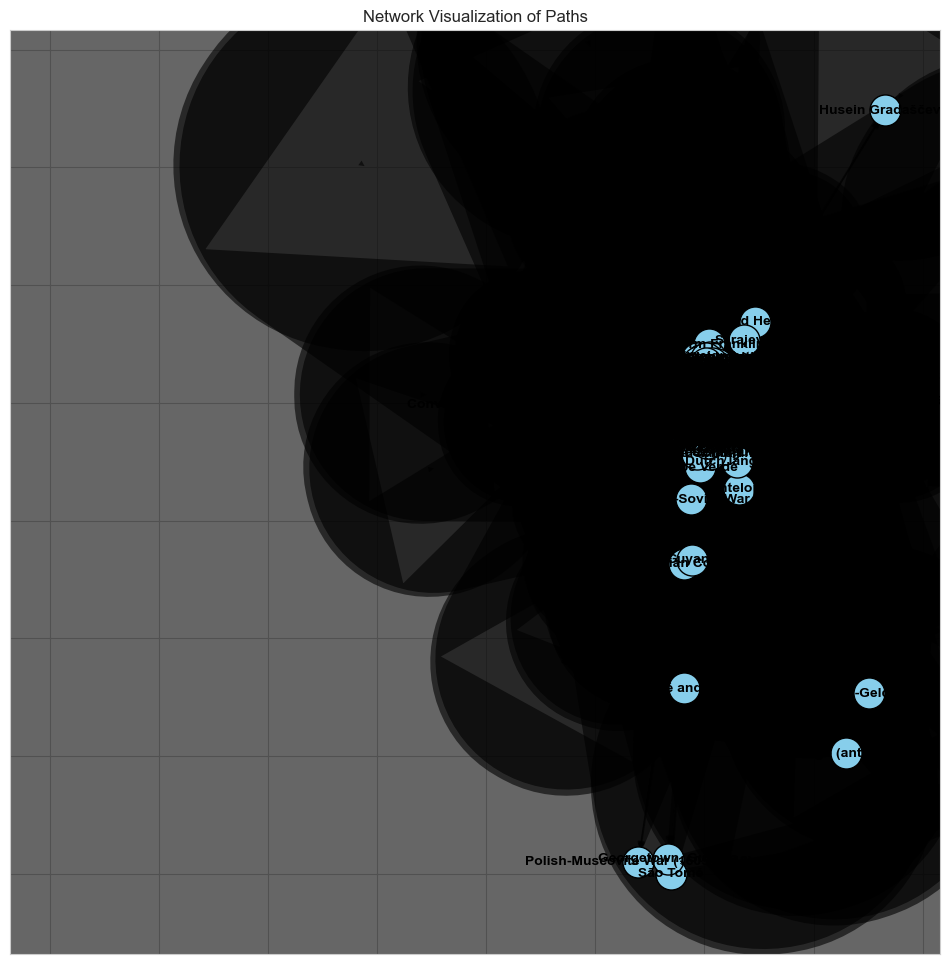

In [171]:
# Initialize a directed graph
G = nx.DiGraph()

# Build the network from paths
for path in df_finished['path']:
    nodes = path.split(';')
    for i in range(len(nodes) - 1):
        # Add edges to the graph with weight based on occurrences
        if G.has_edge(nodes[i], nodes[i + 1]):
            G[nodes[i]][nodes[i + 1]]['weight'] += 1
        else:
            G.add_edge(nodes[i], nodes[i + 1], weight=1)

# Plotting the network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent positioning
edges = G.edges(data=True)

# Draw nodes and edges with weights
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue", edgecolors="black")
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edge[2]['weight']*0.5 for edge in edges], alpha=0.6, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title("Network Visualization of Paths")
plt.show()